# CSE 598: Machine Learning Security and Fairness
## Universal Adversarial Perturbations
- Submitted by:
  - Arshdeep Singh
  - Vibhor Agarwal

## Description
- This contains code for generating Universal Adversarial Pertubation(UAP) for ImageNet dataset
- The model that was used to test this perturbation was 'Inception' model
- A single image from the test set is used against this pertubation to show that UAP can misclassify the image given the model.



In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
import os.path
import matplotlib.pyplot as plt
import sys, getopt
import zipfile
from timeit import time
import os
from imageio import imread
from cv2 import resize

In [ ]:
def deepfool(image, f, grads, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image of size HxWx3
       :param f: feedforward function (input: images, output: values of activation BEFORE softmax).
       :param grads: gradient functions with respect to input (as many gradients as classes).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 10)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """

    f_image = np.array(f(image)).flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.shape
    pert_image = image

    f_i = np.array(f(pert_image)).flatten()
    k_i = int(np.argmax(f_i))

    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape) # we need to change this to previous computed value

    loop_i = 0

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        gradients = np.asarray(grads(pert_image,I))

        for k in range(1, num_classes):

            # set new w_k and new f_k
            w_k = gradients[k, :, :, :, :] - gradients[0, :, :, :, :]
            f_k = f_i[I[k]] - f_i[I[0]]
            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        r_i =  pert * w / np.linalg.norm(w)
        r_tot = r_tot + r_i

        # compute new perturbed image
        pert_image = image + (1+overshoot)*r_tot
        loop_i += 1

        # compute new label
        f_i = np.array(f(pert_image)).flatten()
        k_i = int(np.argmax(f_i))

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, k_i, pert_image

In [ ]:
def proj_lp(v, xi, p):

    # Project on the lp ball centered at 0 and of radius xi

    # SUPPORTS only p = 2 and p = Inf for now
    if p == 2:
        v = v * min(1, xi/np.linalg.norm(v.flatten(1)))
        # v = v / np.linalg.norm(v.flatten(1)) * xi
    elif p == np.inf:
        v = np.sign(v) * np.minimum(abs(v), xi)
    else:
         raise ValueError('Values of p different from 2 and Inf are currently not supported...')

    return v

In [ ]:
def universal_perturbation(dataset, f, grads, delta=0.2, max_iter_uni = np.inf, xi=10, p=np.inf, num_classes=10, overshoot=0.02, max_iter_df=10):
    """
    :param dataset: Images of size MxHxWxC (M: number of images)

    :param f: feedforward function (input: images, output: values of activation BEFORE softmax).

    :param grads: gradient functions with respect to input (as many gradients as classes).

    :param delta: controls the desired fooling rate (default = 80% fooling rate)

    :param max_iter_uni: optional other termination criterion (maximum number of iteration, default = np.inf)

    :param xi: controls the l_p magnitude of the perturbation (default = 10)

    :param p: norm to be used (FOR NOW, ONLY p = 2, and p = np.inf ARE ACCEPTED!) (default = np.inf)

    :param num_classes: num_classes (limits the number of classes to test against, by default = 10)

    :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).

    :param max_iter_df: maximum number of iterations for deepfool (default = 10)

    :return: the universal perturbation.
    """

    v = 0
    fooling_rate = 0.0
    num_images =  np.shape(dataset)[0] # The images should be stacked ALONG FIRST DIMENSION

    itr = 0
    while fooling_rate < 1-delta and itr < max_iter_uni:
        # Shuffle the dataset
        np.random.shuffle(dataset)

        print ('Starting pass number ', itr)

        # Go through the data set and compute the perturbation increments sequentially
        for k in range(0, num_images):
            cur_img = dataset[k:(k+1), :, :, :]

            if int(np.argmax(np.array(f(cur_img)).flatten())) == int(np.argmax(np.array(f(cur_img+v)).flatten())):
                print('>> k = ', k, ', pass #', itr)

                # Compute adversarial perturbation
                dr,iter,_,_ = deepfool(cur_img + v, f, grads, num_classes=num_classes, overshoot=overshoot, max_iter=max_iter_df)

                # Make sure it converged...
                if iter < max_iter_df-1:
                    v = v + dr

                    # Project on l_p ball
                    v = proj_lp(v, xi, p)

        itr = itr + 1

        # Perturb the dataset with computed perturbation
        dataset_perturbed = dataset + v

        est_labels_orig = np.zeros((num_images))
        est_labels_pert = np.zeros((num_images))

        batch_size = 100
        num_batches = int(np.ceil(np.float(num_images) / np.float(batch_size)))

        # Compute the estimated labels in batches
        for ii in range(0, num_batches):
            m = (ii * batch_size)
            M = min((ii+1)*batch_size, num_images)
            est_labels_orig[m:M] = np.argmax(f(dataset[m:M, :, :, :]), axis=1).flatten()
            est_labels_pert[m:M] = np.argmax(f(dataset_perturbed[m:M, :, :, :]), axis=1).flatten()

        # Compute the fooling rate
        fooling_rate = float(np.sum(est_labels_pert != est_labels_orig) / float(num_images))
        print('FOOLING RATE = ', fooling_rate)

    return v

In [ ]:
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

In [ ]:
device = '/gpu:0'
num_classes = 10

In [ ]:
def jacobian(y_flat, x, inds):
    n = num_classes # Not really necessary, just a quick fix.
    loop_vars = [
         tf.constant(0, tf.int32),
         tf.TensorArray(tf.float32, size=n),
    ]
    _, jacobian = tf.while_loop(
        lambda j,_: j < n,
        lambda j,result: (j+1, result.write(j, tf.gradients(y_flat[inds[j]], x))),
        loop_vars)
    return jacobian.stack()

In [ ]:
path_train_imagenet = '/datasets2/ILSVRC2012/train'
path_test_image = 'test_img.png'    

In [ ]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [ ]:
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode="rgb", out=None):
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, pilmode='RGB')
        if img_size:
            img = resize(src=img,dsize=img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        # if color_mode=="bgr":
        #    img[:,:,[0,1,2]] = img[:,:,[2,1,0]]

        if crop_size:
            img = img[(img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2, (img_size[1]-crop_size[1])//2:(img_size[1]+crop_size[1])//2, :];

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [ ]:
def undo_image_avg(img):
    img_copy = np.copy(img)
    img_copy[:, :, 0] = img_copy[:, :, 0] + 123.68
    img_copy[:, :, 1] = img_copy[:, :, 1] + 116.779
    img_copy[:, :, 2] = img_copy[:, :, 2] + 103.939
    return img_copy

In [ ]:
def create_imagenet_npy(path_train_imagenet, len_batch=10000):

    # path_train_imagenet = '/datasets2/ILSVRC2012/train';

    sz_img = [224, 224]
    num_channels = 3
    num_classes = 1000

    im_array = np.zeros([len_batch] + sz_img + [num_channels], dtype=np.float32)
    num_imgs_per_batch = int(len_batch / num_classes)

    dirs = [x[0] for x in os.walk(path_train_imagenet)]
    dirs = dirs[1:]

    # Sort the directory in alphabetical order (same as synset_words.txt)
    dirs = sorted(dirs)

    it = 0
    Matrix = [0 for x in range(1000)]

    for d in dirs:
        for _, _, filename in os.walk(os.path.join(path_train_imagenet, d)):
            Matrix[it] = filename
        it = it+1


    it = 0
    # Load images, pre-process, and save
    for k in range(num_classes):
        for u in range(num_imgs_per_batch):
            print('Processing image number ', it)
            path_img = os.path.join(dirs[k], Matrix[k][u])
            image = preprocess_image_batch([path_img],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            im_array[it:(it+1), :, :, :] = image
            it = it + 1

    return im_array

In [ ]:
persisted_sess = tf.compat.v1.Session()

In [ ]:
!mkdir data

In [ ]:
!gdown --id 1hm4-6AbIwvi0WSdInvU7fNe_bbStl1Dk

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hm4-6AbIwvi0WSdInvU7fNe_bbStl1Dk
To: /content/tensorflow_inception_graph.pb
100% 53.9M/53.9M [00:00<00:00, 61.3MB/s]


In [ ]:
inception_model_path = 'tensorflow_inception_graph.pb'
print(os.path.isfile(inception_model_path))
if os.path.isfile(inception_model_path) == 0:
    print('Downloading Inception model...')
    urlretrieve ("https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip", 'inception5h.zip')
    # Unzipping the file
    zip_ref = zipfile.ZipFile('inception5h.zip', 'r')
    zip_ref.extract('tensorflow_inception_graph.pb')
    zip_ref.close()

model = os.path.join(inception_model_path)

True


In [ ]:
# Load the Inception model
with gfile.FastGFile(model, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    # Store graph in Session storage
    persisted_sess.graph.as_default() 
    tf.import_graph_def(graph_def, name='')

Instructions for updating:
Use tf.gfile.GFile.


In [ ]:
persisted_sess.graph.get_operations()

[<tf.Operation 'input' type=Placeholder>,
 <tf.Operation 'conv2d0_w' type=Const>,
 <tf.Operation 'conv2d0_b' type=Const>,
 <tf.Operation 'conv2d1_w' type=Const>,
 <tf.Operation 'conv2d1_b' type=Const>,
 <tf.Operation 'conv2d2_w' type=Const>,
 <tf.Operation 'conv2d2_b' type=Const>,
 <tf.Operation 'mixed3a_1x1_w' type=Const>,
 <tf.Operation 'mixed3a_1x1_b' type=Const>,
 <tf.Operation 'mixed3a_3x3_bottleneck_w' type=Const>,
 <tf.Operation 'mixed3a_3x3_bottleneck_b' type=Const>,
 <tf.Operation 'mixed3a_3x3_w' type=Const>,
 <tf.Operation 'mixed3a_3x3_b' type=Const>,
 <tf.Operation 'mixed3a_5x5_bottleneck_w' type=Const>,
 <tf.Operation 'mixed3a_5x5_bottleneck_b' type=Const>,
 <tf.Operation 'mixed3a_5x5_w' type=Const>,
 <tf.Operation 'mixed3a_5x5_b' type=Const>,
 <tf.Operation 'mixed3a_pool_reduce_w' type=Const>,
 <tf.Operation 'mixed3a_pool_reduce_b' type=Const>,
 <tf.Operation 'mixed3b_1x1_w' type=Const>,
 <tf.Operation 'mixed3b_1x1_b' type=Const>,
 <tf.Operation 'mixed3b_3x3_bottleneck_w' 

In [ ]:
persisted_input = persisted_sess.graph.get_tensor_by_name("input:0")
persisted_output = persisted_sess.graph.get_tensor_by_name("softmax2_pre_activation:0")

In [ ]:
print('>> Computing feedforward function...')
def f(image_inp): return persisted_sess.run(persisted_output, feed_dict={persisted_input: np.reshape(image_inp, (-1, 224, 224, 3))})

>> Computing feedforward function...


In [ ]:
!gdown --id 11vLx1iDbF9RzwFxVPbwx_TMecy-Y__kl

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11vLx1iDbF9RzwFxVPbwx_TMecy-Y__kl
To: /content/universal.npy
100% 1.20M/1.20M [00:00<00:00, 136MB/s]


In [ ]:
file_perturbation = 'universal2.npy'

In [ ]:
model_present = os.path.isfile(file_perturbation)
model_present

False

In [ ]:
if model_present:
    # Use pretained model
    print('>> Found a pre-computed universal perturbation! Retrieving it from ", file_perturbation')
    v = np.load(file_perturbation)

In [ ]:
if not model_present:
    print('>> Compiling the gradient tensorflow functions. This might take some time...')
    y_flat = tf.reshape(persisted_output, (-1,))
    print(">> Step 1")
    inds = tf.placeholder(tf.int32, shape=(num_classes,))
    print(">> Step 2")
    dydx = jacobian(y_flat,persisted_input,inds)
    print(">> Step 3")

    print('>> Computing gradient function...')
    def grad_fs(image_inp, indices): return persisted_sess.run(dydx, feed_dict={persisted_input: image_inp, inds: indices}).squeeze(axis=1)

    # Load/Create data
    datafile = os.path.join('data', 'imagenet_data.npy')
    if os.path.isfile(datafile) == 0:
        print('>> Creating pre-processed imagenet data...')
        X = create_imagenet_npy(path_train_imagenet)

        print('>> Saving the pre-processed imagenet data')
        if not os.path.exists('data'):
            os.makedirs('data')

        # Save the pre-processed images
        # Caution: This can take take a lot of space. Comment this part to discard saving.
        np.save(os.path.join('data', 'imagenet_data.npy'), X)

    else:
        print('>> Pre-processed imagenet data detected')
        X = np.load(datafile)

    # Running universal perturbation
    v = universal_perturbation(X, f, grad_fs, delta=0.2,num_classes=num_classes)

    # Saving the universal perturbation
    np.save(os.path.join(file_perturbation), v)

>> Compiling the gradient tensorflow functions. This might take some time...


TypeError: ignored

In [ ]:
!gdown --id 12xdeqTgkhKFy6dL6fo3xDwl01qfa00ls

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12xdeqTgkhKFy6dL6fo3xDwl01qfa00ls
To: /content/labels.txt
100% 21.7k/21.7k [00:00<00:00, 29.5MB/s]


In [ ]:
!gdown --id 1UyPGFgy8RY0LUy5EoBWIEC0JG8CBdvD5

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UyPGFgy8RY0LUy5EoBWIEC0JG8CBdvD5
To: /content/test_img.png
100% 249k/249k [00:00<00:00, 119MB/s]


In [ ]:
print('>> Testing the universal perturbation on an image')
labels = open('labels.txt', 'r').read().split('\n')
image_original = preprocess_image_batch([path_test_image], img_size=(256, 256), crop_size=(224, 224), color_mode="rgb")
label_original = np.argmax(f(image_original), axis=1).flatten()
str_label_original = labels[int(label_original)-1].split(',')[0]
clipped_v = np.clip(undo_image_avg(image_original[0,:,:,:]+v[0,:,:,:]), 0, 255) - np.clip(undo_image_avg(image_original[0,:,:,:]), 0, 255)
image_perturbed = image_original + clipped_v[None, :, :, :]
label_perturbed = np.argmax(f(image_perturbed), axis=1).flatten()
str_label_perturbed = labels[int(label_perturbed)-1].split(',')[0]

>> Testing the universal perturbation on an image


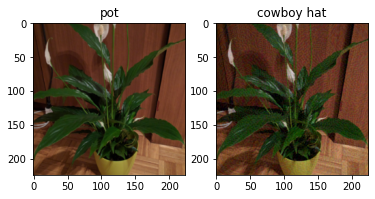

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(undo_image_avg(image_original[0, :, :, :]).astype(dtype='uint8'), interpolation=None)
plt.title(str_label_original)

plt.subplot(1, 2, 2)
plt.imshow(undo_image_avg(image_perturbed[0, :, :, :]).astype(dtype='uint8'), interpolation=None)
plt.title(str_label_perturbed)

plt.show()